In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import numpy as np
import scipy as sp
import math
import torch
import optuna
import torch.autograd as autograd
import matplotlib.pyplot as plt
import inspect
import textwrap
import time

from typing import Callable
from torch import nn, optim
from sklearn.model_selection import KFold
from data_PINN import diffeq, create_trainig_test_set, create_trainig_validation_test_set
from tqdm import tqdm

import torch.nn.functional as F

torch.use_deterministic_algorithms(True)

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"

print(device)

cuda


## Defining the differential equation

We are using the differential equation of a harmonic oscillator:

$m \frac{d^2 x}{dt^2} +kx = 0$

In [4]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

# 1. First try

## Generating datasets

TODO: implement data generation with analytical solution

In [5]:
#define the harmonic oscillator class (which ode's, number of variables: x,y, number of arguments: k)
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

#create training and test datasets (which diffeq, timespan, how many timesteps, how many initial conditions (datasets with each 100 timepoints), fraction of test sets, which numerical method to compare, which device, random seed to create data)
train, test = create_trainig_test_set(harmonic_osc, (0, 10), 100, 1000, 0.3, "analytic_harmonic", device=device, seed=0)

#note: device:cuda did not work

In [6]:
print(train["X"].shape)
print(train["y_tensor"][0:, 0:, 0].unsqueeze(-1).shape)
print(train["t_tensor"].shape)
print(train["args_tensor"].shape)

torch.Size([700, 100, 4])
torch.Size([700, 100, 1])
torch.Size([700, 100])
torch.Size([700, 1])


In [7]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.linear = nn.Linear(in_features=n_in, out_features=32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.tanh(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = HarmonicModel(4).to(device)

In [8]:
def loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True).to(device)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1).repeat(1, n_rep, 1)
    x_00_f = x_00.unsqueeze(-1).repeat(1, n_rep, 1)
    x_01_f = x_01.unsqueeze(-1).repeat(1, n_rep, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
epochs = 1000

for epoch in range(epochs):
    X = train["X"]
    y_exp = train["y_tensor"][0:, 0:, 0].to(device)
    y_pred = model(X).squeeze(-1)
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

/home/izpodperda/University/Master/MachineLearning/Project/Machine-learning-project/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100/1000, Loss: 0.5821
Epoch 200/1000, Loss: 0.4133
Epoch 300/1000, Loss: 0.2281
Epoch 400/1000, Loss: 0.1715
Epoch 500/1000, Loss: 0.1228
Epoch 600/1000, Loss: 0.1019
Epoch 700/1000, Loss: 0.0902
Epoch 800/1000, Loss: 0.0820
Epoch 900/1000, Loss: 0.0744
Epoch 1000/1000, Loss: 0.0688


In [11]:
model.eval()
X = test["X"]
y_exp = test["y_tensor"][0:, 0:, 0].to(device)
y_pred = model(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0848


torch.Size([300, 100])


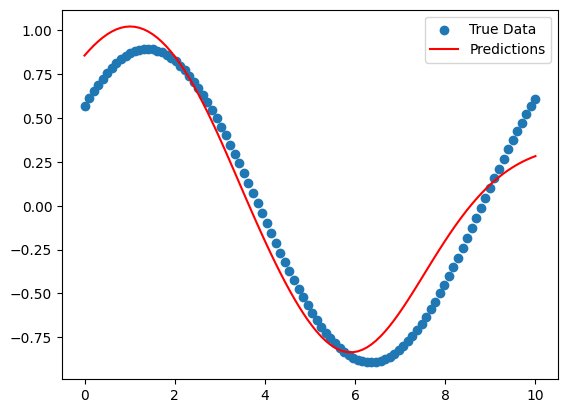

In [12]:
print(y_pred.shape)
y_pred.to("cpu")
test["t_tensor"].to("cpu")

n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

# 2. Hyperparameter optimization using random search

## Generating datasets

In [13]:
train2, validation2, test2 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "analytic_harmonic", device=device, seed=0)

In [14]:
print(train2["X"].shape)
print(validation2["X"].shape)
print(test2["X"].shape)

torch.Size([500, 100, 4])
torch.Size([200, 100, 4])
torch.Size([300, 100, 4])


## Defining the model

A model receives the number of initial parameters n_i, the number of hidden layers n_layers, number of neurons per layer and the activation function.

TODO: implement different number of neurons for each layer, coefficients for loss terms, learning rate

In [15]:
class HarmonicModel2(nn.Module):
    def __init__(self, n_in, n_layers, n_neurons, activation):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, n_neurons))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
        layers.append(nn.Linear(n_neurons, 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel2(4, 2, 32, 'tanh').to(device)

In [16]:
def loss_PINN2(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True).to(device)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1).repeat(1, n_rep, 1)
    x_00_f = x_00.unsqueeze(-1).repeat(1, n_rep, 1)
    x_01_f = x_01.unsqueeze(-1).repeat(1, n_rep, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

In [17]:
def train_PINN2(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        t = X[0:, 0:, 3]
        k = X[0:, 0:, 0]
        x_00 = X[0:, 0:, 1]
        x_01 = X[0:, 0:, 2]
    
        loss = loss_PINN2(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
    
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        # if (epoch+1) % (int(epochs/10)) == 0:
        #     print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return loss.item()



## Optimizing hyperparemeters

In [18]:
#layers_i, neurons_i, ... = interval of randomized values
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, data, seed=0):
    result = []
    torch.manual_seed(seed)
    layers = torch.randint(layers_i[0], layers_i[-1], (n_trials,)).to(device)
    neurons = torch.randint(neurons_i[0], neurons_i[-1], (n_trials,)).to(device)
    activations_idx = torch.randint(0, len(activations_l), (n_trials,)).to(device)
    activations = [activations_l[i] for i in activations_idx]

    for i in range(n_trials):
        params = {
            'n_layers': layers[i],
            'n_neurons': neurons[i],
            'activation': activations[i]
        }

        model = HarmonicModel2(4, params['n_layers'].item(), params['n_neurons'].item(), params['activation']).to(device)
        final_loss = train_PINN2(model, 0.01, 100, data)
        result.append((params, final_loss))

        if (i+1) % (int(n_trials/10)) == 0:
            print(f'{i+1}/{n_trials}')
    
    return result

In [19]:
n_trials = 100
results = rng_hparameters_search(n_trials, (1, 10), (1, 100), ['tanh', 'sine', 'gelu', 'relu'], validation2, seed=0)

10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100


In [20]:
best_params, best_loss = min(results, key=lambda x: x[1])
print("\nBest configuration:")
print(best_params)
print(f"Final loss: {best_loss:.3e}")


Best configuration:
{'n_layers': tensor(6, device='cuda:0'), 'n_neurons': tensor(72, device='cuda:0'), 'activation': 'sine'}
Final loss: 3.988e-02


Best configuration:
{'n_layers': tensor(6, device='cuda:0'), 'n_neurons': tensor(60, device='cuda:0'), 'activation': 'sine'}
Final loss: 1.515e-02


## Testing found hyperparameters

In [21]:
model_optimized = HarmonicModel2(4, 6, 60, 'sine').to(device)

In [22]:
# training
loss_last = train_PINN2(model_optimized, 0.01, 1000, train2)

In [23]:
# test dataset
model_optimized.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred = model_optimized(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN2(y_pred, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0234


torch.Size([300, 100])


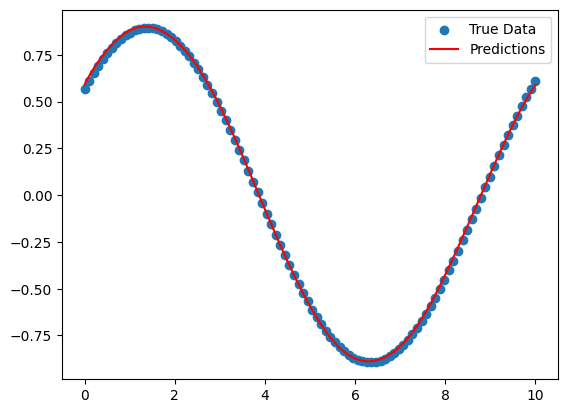

In [24]:
print(y_pred.shape)
y_pred.to("cpu")
test2["t_tensor"].to("cpu")

n = 30
plt.scatter(test2["t_tensor"][n], test2["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test2["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

# 3. Hyperparameter optimization using Optuna

## Generating datasets

In [17]:
train3, validation3, test3 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 50, 1000, [0.5, 0.2, 0.3], "analytic_harmonic", device=device, seed=0)

In [18]:
print(train3["X"].shape)
print(validation3["X"].shape)
print(test3["X"].shape)

torch.Size([500, 50, 4])
torch.Size([200, 50, 4])
torch.Size([300, 50, 4])


## Defining the model

In [19]:
class HarmonicModel3(nn.Module):
    def __init__(self, n_in: int, n_hidden_layers: int, hidden_neurons: list, activation: str):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, hidden_neurons[0]))
        for i in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons[i], hidden_neurons[i+1]))
        layers.append(nn.Linear(hidden_neurons[-1], 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel3(4, 5, [32, 16, 8, 4, 2], 'tanh').to(device)
model

HarmonicModel3(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): Linear(in_features=4, out_features=2, bias=True)
    (5): Linear(in_features=2, out_features=1, bias=True)
  )
  (activation): Tanh()
)

In [20]:
def loss_PINN3(model, y_pred, y_exp, x_00, x_01, t, k, N_f, l_y, l_f, seed=0):    
    torch.manual_seed(seed)
    
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    batch_size_f = 256
    num_batches = (N_f + batch_size_f - 1) // batch_size_f
    mse_f = 0.0

    for i in range(num_batches):
        N_f_c = min(batch_size_f, N_f)
        N_f -= N_f_c

        t_f = (torch.max(t) * torch.rand(N_f_c).to(device)).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True).to(device)

        k_f = k.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f_c, 1)
        x_00_f = x_00.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f_c, 1)
        x_01_f = x_01.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f_c, 1)

        X_batch = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)

        y_b = model(X_batch)
        x_t = autograd.grad(y_b, t_f, grad_outputs=torch.ones_like(y_b),
                            create_graph=True, allow_unused=True)[0]
        x_tt = autograd.grad(x_t, t_f, grad_outputs=torch.ones_like(x_t),
                             create_graph=True, allow_unused=True)[0]

        f_res = x_tt + k_f * y_b
        mse_f = mse_f + torch.mean(f_res**2).detach()

        del X_batch, t_f, k_f, x_00_f, x_01_f, y_b, x_t, x_tt, f_res
        torch.cuda.empty_cache()

    mse_f /= num_batches

    return l_y*mse_y + l_f*mse_f

In [21]:
def train_PINN3(model_class, model_args, n_splits, l_y, l_f, optimizer_class, lr, epochs, N_f, data, random_state=0, show_progress=False):
    """
    optimizer_class: e.g. optim.Adam or optim.SGD
    """
    X_full = data["X"]
    y_exp_full = data["y_tensor"][0:, 0:, 0].to(device)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_losses = []

    best_model = None
    best_loss = float("inf")

    #K-fold loop
    for fold_id, (train_idx, val_idx) in enumerate(kf.split(X_full)):
        if show_progress:
            print(f'-----Fold: {fold_id + 1}-----')
        
        X_train = X_full[train_idx].to(device)
        y_train = y_exp_full[train_idx]
        X_val = X_full[val_idx].to(device)
        y_val = y_exp_full[val_idx]

        #New model every fold
        model = model_class(*model_args).to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)

        #Training
        for epoch in range(epochs):
            model.train()
            
            y_pred = model(X_train).squeeze(-1)
            t = X_train[0:, 0:, 3]
            k = X_train[0:, 0:, 0]
            x_00 = X_train[0:, 0:, 1]
            x_01 = X_train[0:, 0:, 2]
        
            loss = loss_PINN3(model, y_pred, y_train, x_00, x_01, t, k, N_f, l_y, l_f)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1) % (int(epochs/10)) == 0 and show_progress:
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

        #Validation
        model.eval()
        #with torch.no_grad():
        y_pred_val = model(X_val).squeeze(-1)
        t_val = X_val[0:, 0:, 3]
        k_val = X_val[0:, 0:, 0]
        x00_val = X_val[0:, 0:, 1]
        x01_val = X_val[0:, 0:, 2]

        val_loss = loss_PINN3(model, y_pred_val, y_val, x00_val, x01_val, t_val, k_val, N_f, l_y, l_f).item()
        if show_progress:
            print(f'\tValidation loss = {val_loss}')

        #Track best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        #Free vram
        del model
        del optimizer
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


    return best_model, best_loss



### Testing previous best model

In [22]:
torch.cuda.empty_cache()

best_model, best_loss = train_PINN3(HarmonicModel3, 
                                    (4, 6, [60, 60, 60, 60, 60, 60], 'sine'), 
                                    n_splits=5,
                                    l_y=1,
                                    l_f=1,
                                    optimizer_class=torch.optim.Adam, 
                                    lr=0.01, 
                                    epochs=100, 
                                    N_f=500, 
                                    data=train3, 
                                    random_state=0,
                                    show_progress=True
                                   )

-----Fold: 1-----
Epoch 10/100, Loss: 0.8105
Epoch 20/100, Loss: 0.6914
Epoch 30/100, Loss: 0.5500
Epoch 40/100, Loss: 0.4908
Epoch 50/100, Loss: 0.5056
Epoch 60/100, Loss: 0.2849
Epoch 70/100, Loss: 0.2309
Epoch 80/100, Loss: 0.1898
Epoch 90/100, Loss: 0.1179
Epoch 100/100, Loss: 0.1172
	Validation loss = 0.13973581790924072
-----Fold: 2-----
Epoch 10/100, Loss: 0.8149
Epoch 20/100, Loss: 0.6332
Epoch 30/100, Loss: 0.5748
Epoch 40/100, Loss: 0.4641
Epoch 50/100, Loss: 0.3297
Epoch 60/100, Loss: 0.4993
Epoch 70/100, Loss: 0.3352
Epoch 80/100, Loss: 0.1859
Epoch 90/100, Loss: 0.1457
Epoch 100/100, Loss: 0.1111
	Validation loss = 0.13867628574371338
-----Fold: 3-----
Epoch 10/100, Loss: 0.8473
Epoch 20/100, Loss: 0.7127
Epoch 30/100, Loss: 0.6174
Epoch 40/100, Loss: 0.4844
Epoch 50/100, Loss: 0.3949
Epoch 60/100, Loss: 0.2733
Epoch 70/100, Loss: 0.2496
Epoch 80/100, Loss: 0.1779
Epoch 90/100, Loss: 0.1517
Epoch 100/100, Loss: 0.1122
	Validation loss = 0.08467936515808105
-----Fold: 4----

In [23]:
best_model, best_loss

(HarmonicModel3(
   (layers): ModuleList(
     (0): Linear(in_features=4, out_features=60, bias=True)
     (1-5): 5 x Linear(in_features=60, out_features=60, bias=True)
     (6): Linear(in_features=60, out_features=1, bias=True)
   )
 ),
 0.08467936515808105)

In [24]:
# test dataset
best_model.eval()
X = test3["X"]
y_exp = test3["y_tensor"][0:, 0:, 0].to(device)
y_pred = best_model(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN3(best_model, y_pred, y_exp, x_00, x_01, t, k, N_f=100, l_y=1, l_f=1)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.1140


torch.Size([300, 50])


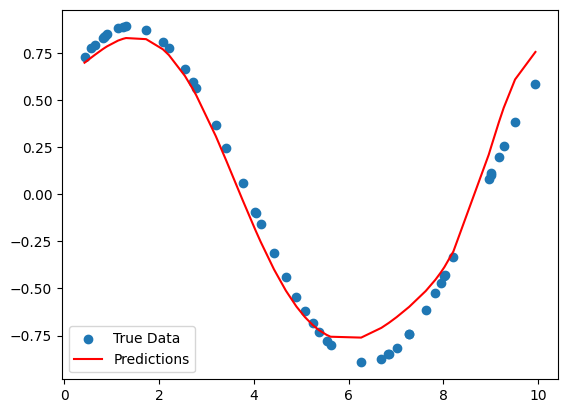

In [25]:
print(y_pred.shape)
y_pred.to("cpu")
test3["t_tensor"].to("cpu")

n = 30
plt.scatter(test3["t_tensor"][n], test3["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test3["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

## Optimizing hyperparameters

Some of the parameters are held constant to minimize the number of iterations (they won't be kept constant for the final work)

In [27]:
def objective(trial):

    #Model hyperparemeters
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 2, 5)
    hidden_neurons = [trial.suggest_int(f"n_neurons{i}", 4, 128, log=True) for i in range(n_hidden_layers)]
    activation = trial.suggest_categorical("activation", ["tanh", "sine", "relu", "gelu"])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    #Loss function hyperparameters
    l_y = trial.suggest_float("l_y", 0.1, 10.0, log=True)
    l_f = trial.suggest_float("l_f", 0.1, 10.0, log=True)
    N_f = trial.suggest_int("N_f", 100, 2000) #to change

    #Training hyperparameters
    epochs = trial.suggest_int("epochs", 10, 200) #to change
    n_splits = trial.suggest_int("n_splits", 2, 10)
    optimizers = [torch.optim.Adam, torch.optim.SGD, 
                  torch.optim.RMSprop, torch.optim.Adagrad,
                  torch.optim.ASGD, torch.optim.Rprop]
    optimizer_idx = trial.suggest_int("optimizer_idx", 0, len(optimizers) - 1)
    optimizer_class = optimizers[optimizer_idx]

    model_args = (4, n_hidden_layers, hidden_neurons, activation)

    #Training using K-fold
    best_model, best_loss = train_PINN3(
        model_class=HarmonicModel3,
        model_args=model_args,
        n_splits=5,
        l_y=1,
        l_f=1,
        optimizer_class=optimizer_class,
        lr=lr,
        epochs=100,
        N_f=N_f,
        data=train3,
        random_state=trial.number,
        show_progress=False
    )

    return best_loss

In [28]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=0),
    study_name="PINN_harmonic_oscillator",
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=10)
)

study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

[I 2025-12-08 18:28:13,426] A new study created in memory with name: PINN_harmonic_oscillator


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-08 18:29:16,789] Trial 0 finished with value: 0.6488338112831116 and parameters: {'n_hidden_layers': 4, 'n_neurons0': 46, 'n_neurons1': 31, 'n_neurons2': 25, 'n_neurons3': 16, 'activation': 'gelu', 'lr': 0.0005846326121643416, 'l_y': 3.832216850492789, 'l_f': 1.1423254155608376, 'N_f': 1179, 'epochs': 186, 'n_splits': 2, 'optimizer_idx': 0}. Best is trial 0 with value: 0.6488338112831116.
[I 2025-12-08 18:29:35,493] Trial 1 finished with value: 0.26900631189346313 and parameters: {'n_hidden_layers': 2, 'n_neurons0': 70, 'n_neurons1': 58, 'activation': 'sine', 'lr': 0.0036396393567863887, 'l_y': 0.17240460099242294, 'l_f': 1.9047678084282036, 'N_f': 372, 'epochs': 190, 'n_splits': 6, 'optimizer_idx': 2}. Best is trial 1 with value: 0.26900631189346313.
[I 2025-12-08 18:30:15,092] Trial 2 finished with value: 0.6782665252685547 and parameters: {'n_hidden_layers': 3, 'n_neurons0': 57, 'n_neurons1': 18, 'n_neurons2': 27, 'activation': 'sine', 'lr': 0.007717846862118065, 'l_y': 2

In [29]:
print("Best hyperparameters:", study.best_trial.params)
print("Best value:", study.best_value)

Best hyperparameters: {'n_hidden_layers': 5, 'n_neurons0': 25, 'n_neurons1': 12, 'n_neurons2': 10, 'n_neurons3': 33, 'n_neurons4': 116, 'activation': 'gelu', 'lr': 0.005752663593253954, 'l_y': 1.3871008857589113, 'l_f': 0.31547937295474965, 'N_f': 112, 'epochs': 83, 'n_splits': 8, 'optimizer_idx': 5}
Best value: 0.023255517706274986


## Testing new best hyperparameters

In [30]:
torch.cuda.empty_cache()

best_model_new, best_loss_new = train_PINN3(HarmonicModel3, 
                                    (4, 5, [25, 12, 10, 33, 116], 'gelu'), 
                                    n_splits=5,
                                    l_y=1,
                                    l_f=1,
                                    optimizer_class=torch.optim.Rprop, 
                                    lr=0.005752663593253954, 
                                    epochs=1000, 
                                    N_f=112, 
                                    data=train3, 
                                    random_state=0,
                                    show_progress=True
                                   )

-----Fold: 1-----
Epoch 100/1000, Loss: 0.0417
Epoch 200/1000, Loss: 0.0217
Epoch 300/1000, Loss: 0.0177
Epoch 400/1000, Loss: 0.0230
Epoch 500/1000, Loss: 0.0328
Epoch 600/1000, Loss: 0.0274
Epoch 700/1000, Loss: 0.0319
Epoch 800/1000, Loss: 0.0268
Epoch 900/1000, Loss: 0.0206
Epoch 1000/1000, Loss: 0.0158
	Validation loss = 0.016075342893600464
-----Fold: 2-----
Epoch 100/1000, Loss: 0.0651
Epoch 200/1000, Loss: 0.1213
Epoch 300/1000, Loss: 0.0569
Epoch 400/1000, Loss: 0.0424
Epoch 500/1000, Loss: 0.0264
Epoch 600/1000, Loss: 0.0217
Epoch 700/1000, Loss: 0.0202
Epoch 800/1000, Loss: 0.0195
Epoch 900/1000, Loss: 0.0186
Epoch 1000/1000, Loss: 0.0179
	Validation loss = 0.026035601273179054
-----Fold: 3-----
Epoch 100/1000, Loss: 0.0722
Epoch 200/1000, Loss: 0.0189
Epoch 300/1000, Loss: 0.0129
Epoch 400/1000, Loss: 0.0108
Epoch 500/1000, Loss: 0.0100
Epoch 600/1000, Loss: 0.0100
Epoch 700/1000, Loss: 0.0093
Epoch 800/1000, Loss: 0.0089
Epoch 900/1000, Loss: 0.0084
Epoch 1000/1000, Loss: 

In [31]:
best_model_new, best_loss_new

(HarmonicModel3(
   (layers): ModuleList(
     (0): Linear(in_features=4, out_features=25, bias=True)
     (1): Linear(in_features=25, out_features=12, bias=True)
     (2): Linear(in_features=12, out_features=10, bias=True)
     (3): Linear(in_features=10, out_features=33, bias=True)
     (4): Linear(in_features=33, out_features=116, bias=True)
     (5): Linear(in_features=116, out_features=1, bias=True)
   )
   (activation): GELU(approximate='none')
 ),
 0.008117703720927238)

In [20]:
#Save the model
torch.save(best_model_new.state_dict(), "optimized_model_PINN.pt")

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [39]:
#Load a model
best_model_new = HarmonicModel3(4, 5, [88, 19, 21, 66, 26], 'gelu').to(device)
best_model_new.load_state_dict(torch.load("optimized_model_PINN.pt"))
best_model_new.eval()

HarmonicModel3(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=88, bias=True)
    (1): Linear(in_features=88, out_features=19, bias=True)
    (2): Linear(in_features=19, out_features=21, bias=True)
    (3): Linear(in_features=21, out_features=66, bias=True)
    (4): Linear(in_features=66, out_features=26, bias=True)
    (5): Linear(in_features=26, out_features=1, bias=True)
  )
  (activation): GELU(approximate='none')
)

In [40]:
# test dataset
X = test3["X"]
y_exp = test3["y_tensor"][0:, 0:, 0].to(device)
y_pred = best_model_new(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN3(best_model_new, y_pred, y_exp, x_00, x_01, t, k, N_f=174, l_y=1, l_f=1)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0025


torch.Size([300, 50])


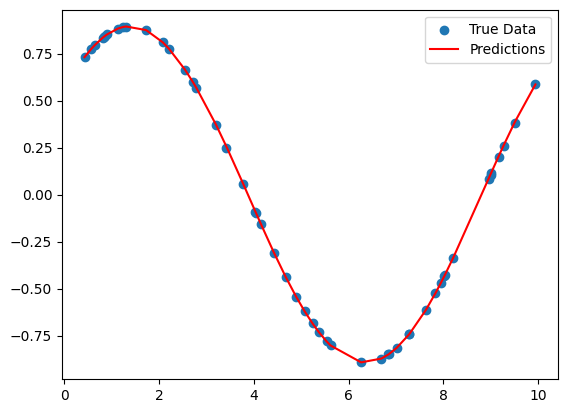

In [41]:
print(y_pred.shape)
y_pred.to("cpu")
test3["t_tensor"].to("cpu")

n = 30
plt.scatter(test3["t_tensor"][n], test3["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test3["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

## Test the model on noisy data

In [42]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset

In [43]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.699, 0.001, 0.3], "analytic_harmonic", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_noise = best_model_new(X).squeeze(-1)
y_exp = test_noise["y_tensor"][0:, 0:, 0].to(device)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]


test_loss = loss_PINN3(best_model_new, y_pred_noise, y_exp, x_00, x_01, t, k, N_f=174, l_y=1, l_f=1)
print(f"Test Loss Random optimization: {test_loss:.4f}")

Test Loss Random optimization: 0.1968


/tmp/ipykernel_39485/3632768158.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


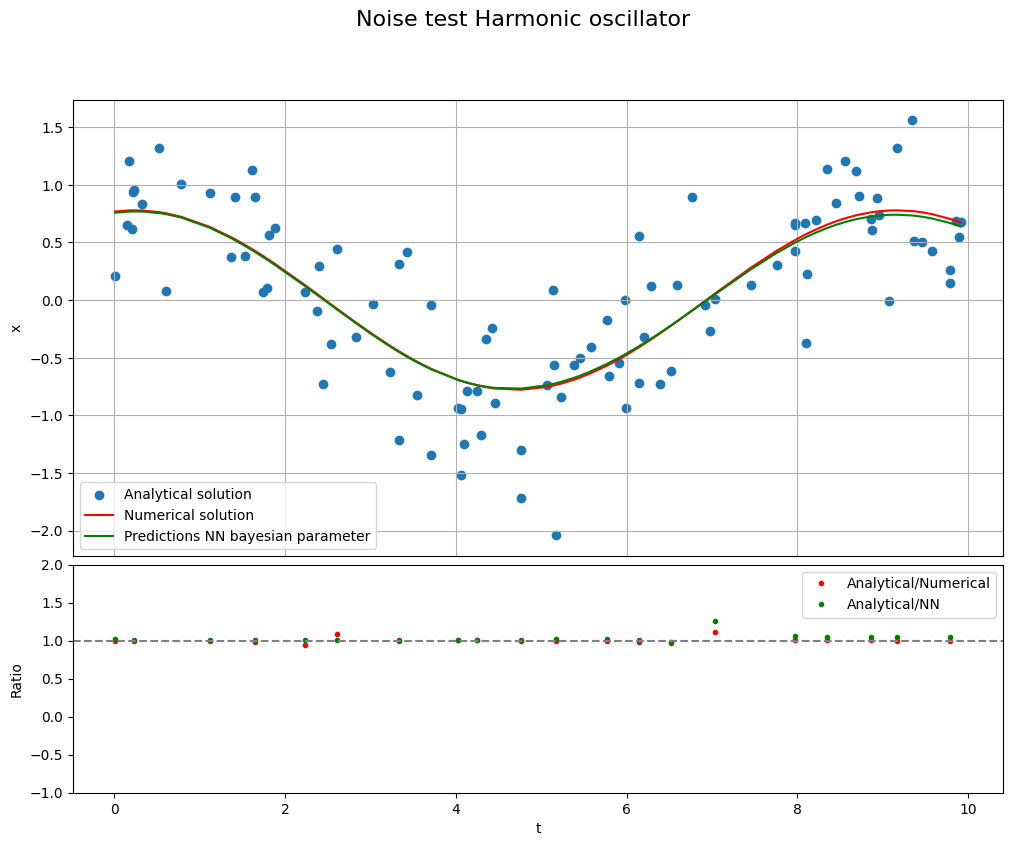

In [44]:
n = 0

y_pred_noise.to(device)
test_noise["t_tensor"].to(device)

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

## Test generalization

In [45]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 200, 1, [0.699, 0.001, 0.3], "analytic_harmonic", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization = best_model_new(X).squeeze(-1)
y_exp_generalization = test_generalization["y_tensor"][0:, 0:, 0].to(device)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]

test_loss = loss_PINN3(best_model_new, y_pred_generalization, y_exp_generalization, x_00, x_01, t, k, N_f=174, l_y=1, l_f=1)
print(f"Test Loss Random optimization: {test_loss:.4f}")

Test Loss Random optimization: 0.2150


/tmp/ipykernel_39485/94008576.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


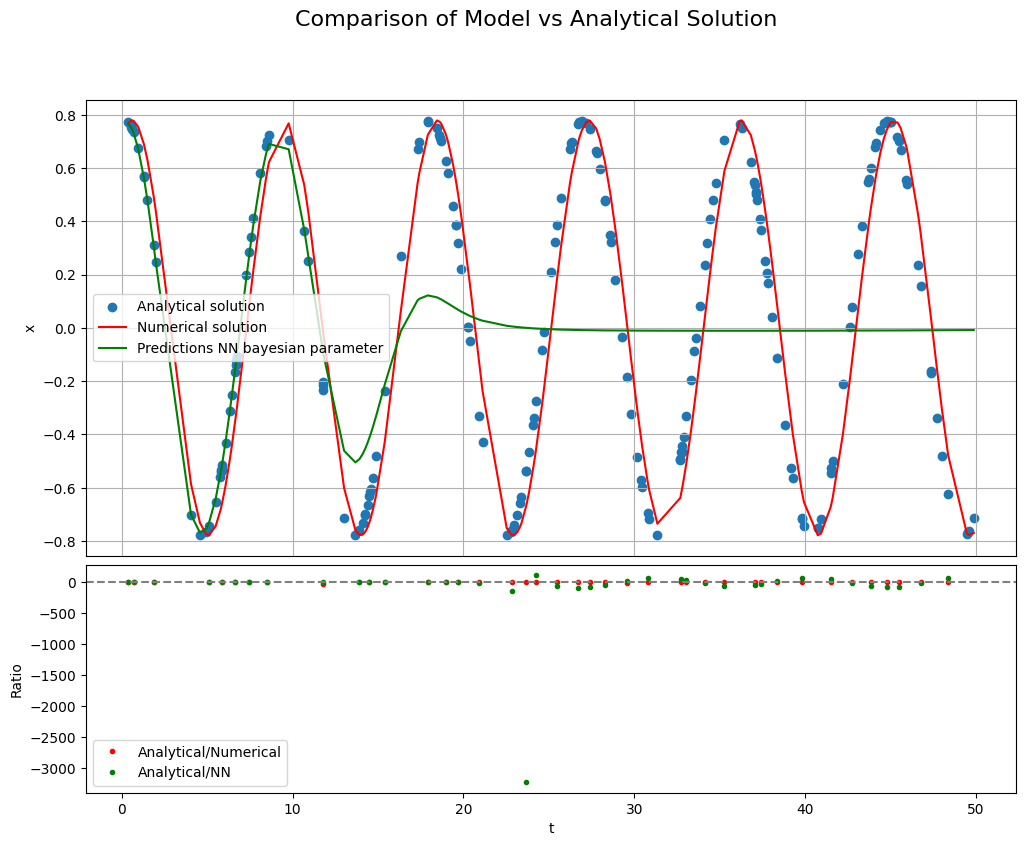

In [46]:
n = 0

y_pred_generalization.to(device)
test_generalization["t_tensor"].to(device)

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
#ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

## Test physical quantities

### Energy conservation

Initial energy E0 = 1.480842e-01
Max absolute deviation = 1.480756e-01
Max relative deviation = 9.999418e-01


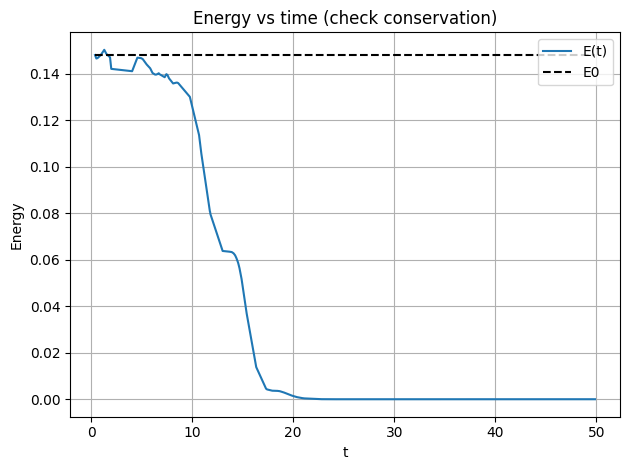

In [47]:
n = 0  # choose trajectory index

# Position
x = y_pred_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time (check conservation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
n=0

#Computation time
N = 200
timesteps_NN = np.zeros(N)
timesteps_Num = np.zeros(N)
N_list = np.arange(0,N)

X = test["X"][n]
y0 = [test["x0_tensor"][n][0], test["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test["t_tensor"][n][0], test["t_tensor"][n][-1]
w = test["args_tensor"][n]

#NN
for i, el in tqdm(enumerate(N_list), desc="Computation time NN: "):
    begin = time.perf_counter()
    for _ in range(el):
        best_model_new(X)
    end = time.perf_counter()
    timesteps_NN[i] = end-begin

#Numerical
for i, el in tqdm(enumerate(N_list), desc="Computation time Numerical: "):
    begin = time.perf_counter()
    for _ in range(el):
        sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test["t_tensor"][n], method='RK45', args=(w))
    end = time.perf_counter()
    timesteps_Num[i] = end-begin

Computation time NN: : 200it [00:14, 13.52it/s]
Computation time Numerical: : 200it [00:45,  4.37it/s]


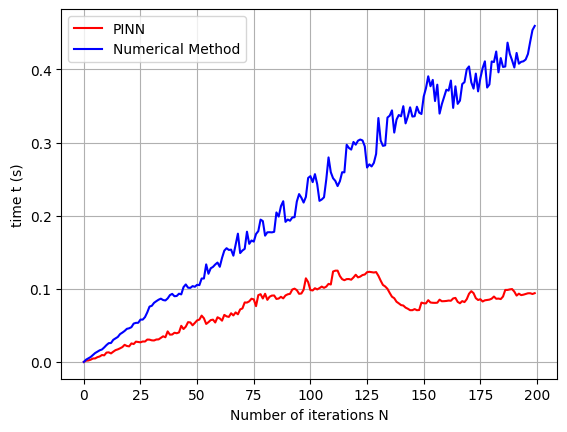

In [49]:
#Plot computational time
plt.plot(N_list, timesteps_NN, color='red', label="PINN")
plt.plot(N_list, timesteps_Num, color='blue', label="Numerical Method")
plt.xlabel("Number of iterations N")
plt.ylabel("time t (s)")
plt.grid(True)
plt.legend()
plt.show()